In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### CIFAR-10 Dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### VGG Model

In [33]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG18': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'VGG34': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
              512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512 * 2 * 2, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2, padding=1)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG('VGG34')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

# test()

#### ResNet Model

In [57]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

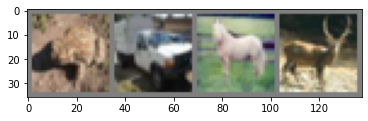

 frog truck horse  deer


In [23]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [24]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [34]:
# We define our models.
vgg_18 = VGG('VGG18')
vgg_34 = VGG('VGG34')
resnet_18 = ResNet18()
resnet_34 = ResNet34()
# We move models to device.
vgg_18.to(device)
vgg_34.to(device)
resnet_18.to(device)
resnet_34.to(device)
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
sgd_opt = optim.SGD(vgg_18.parameters(), lr=0.001, momentum=0.9) 
# We use Adam optimizer.
adam_opt = optim.Adam(vgg_18.parameters(), lr=0.001)

#### VGG18 SGD

In [40]:
avg_losses_vgg18_sgd = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 1000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        sgd_opt.zero_grad()

        # Forward step.
        outputs = vgg_18(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        sgd_opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses_vgg18_sgd.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:   999] avg mini-batch loss: 2.478
[epoch: 0, i:  1999] avg mini-batch loss: 2.002
[epoch: 0, i:  2999] avg mini-batch loss: 1.774
[epoch: 0, i:  3999] avg mini-batch loss: 1.660
[epoch: 0, i:  4999] avg mini-batch loss: 1.552
[epoch: 0, i:  5999] avg mini-batch loss: 1.454
[epoch: 0, i:  6999] avg mini-batch loss: 1.377
[epoch: 0, i:  7999] avg mini-batch loss: 1.317
[epoch: 0, i:  8999] avg mini-batch loss: 1.253
[epoch: 0, i:  9999] avg mini-batch loss: 1.191
[epoch: 0, i: 10999] avg mini-batch loss: 1.175
[epoch: 0, i: 11999] avg mini-batch loss: 1.080
[epoch: 1, i:   999] avg mini-batch loss: 1.036
[epoch: 1, i:  1999] avg mini-batch loss: 1.000
[epoch: 1, i:  2999] avg mini-batch loss: 0.932
[epoch: 1, i:  3999] avg mini-batch loss: 0.971
[epoch: 1, i:  4999] avg mini-batch loss: 0.927
[epoch: 1, i:  5999] avg mini-batch loss: 0.899
[epoch: 1, i:  6999] avg mini-batch loss: 0.849
[epoch: 1, i:  7999] avg mini-batch loss: 0.892
[epoch: 1, i:  8999] avg mini-batch loss

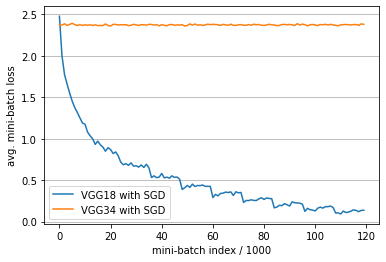

In [42]:
plt.plot(avg_losses_vgg18_sgd, label='VGG18 with SGD')
plt.plot(avg_losses_vgg34_sgd, label='VGG34 with SGD')
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.grid(axis='y')
plt.legend()
plt.show()

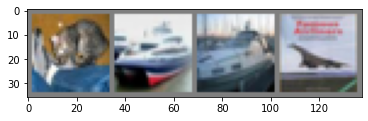

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [13]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = vgg_18(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [14]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg_18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of VGG18 with SGD on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of VGG18 on the 10000 test images: 80 %


In [15]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg_18(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86 %
Accuracy of   car : 90 %
Accuracy of  bird : 62 %
Accuracy of   cat : 70 %
Accuracy of  deer : 82 %
Accuracy of   dog : 65 %
Accuracy of  frog : 87 %
Accuracy of horse : 87 %
Accuracy of  ship : 87 %
Accuracy of truck : 85 %


#### VGG34 SGD

In [41]:
avg_losses_vgg34_sgd = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 1000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        sgd_opt.zero_grad()

        # Forward step.
        outputs = vgg_34(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        sgd_opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses_vgg34_sgd.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:   999] avg mini-batch loss: 2.373
[epoch: 0, i:  1999] avg mini-batch loss: 2.371
[epoch: 0, i:  2999] avg mini-batch loss: 2.387
[epoch: 0, i:  3999] avg mini-batch loss: 2.368
[epoch: 0, i:  4999] avg mini-batch loss: 2.380
[epoch: 0, i:  5999] avg mini-batch loss: 2.392
[epoch: 0, i:  6999] avg mini-batch loss: 2.378
[epoch: 0, i:  7999] avg mini-batch loss: 2.366
[epoch: 0, i:  8999] avg mini-batch loss: 2.377
[epoch: 0, i:  9999] avg mini-batch loss: 2.368
[epoch: 0, i: 10999] avg mini-batch loss: 2.374
[epoch: 0, i: 11999] avg mini-batch loss: 2.370
[epoch: 1, i:   999] avg mini-batch loss: 2.374
[epoch: 1, i:  1999] avg mini-batch loss: 2.367
[epoch: 1, i:  2999] avg mini-batch loss: 2.374
[epoch: 1, i:  3999] avg mini-batch loss: 2.366
[epoch: 1, i:  4999] avg mini-batch loss: 2.367
[epoch: 1, i:  5999] avg mini-batch loss: 2.365
[epoch: 1, i:  6999] avg mini-batch loss: 2.385
[epoch: 1, i:  7999] avg mini-batch loss: 2.366
[epoch: 1, i:  8999] avg mini-batch loss

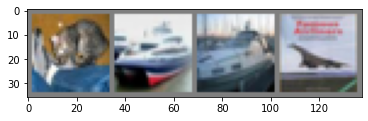

GroundTruth:    cat  ship  ship plane
Predicted:  plane  frog  frog  frog


In [43]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = vgg_34(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [44]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg_34(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of VGG34 with SGD on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of VGG18 on the 10000 test images: 11 %


In [45]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg_34(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 16 %
Accuracy of   car :  8 %
Accuracy of  bird :  0 %
Accuracy of   cat :  1 %
Accuracy of  deer : 21 %
Accuracy of   dog :  0 %
Accuracy of  frog : 58 %
Accuracy of horse : 11 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


#### Plot for VGG18 and VGG34 with SGD

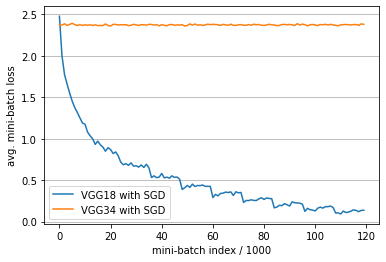

In [47]:
plt.plot(avg_losses_vgg18_sgd, label='VGG18 with SGD')
plt.plot(avg_losses_vgg34_sgd, label='VGG34 with SGD')
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.grid(axis='y')
plt.legend()
plt.show()

#### VGG18 Adam

In [48]:
avg_losses_vgg18_adam = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 1000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        adam_opt.zero_grad()

        # Forward step.
        outputs = vgg_18(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        adam_opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses_vgg18_adam.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:   999] avg mini-batch loss: 1.314
[epoch: 0, i:  1999] avg mini-batch loss: 1.119
[epoch: 0, i:  2999] avg mini-batch loss: 1.031
[epoch: 0, i:  3999] avg mini-batch loss: 0.998
[epoch: 0, i:  4999] avg mini-batch loss: 0.951
[epoch: 0, i:  5999] avg mini-batch loss: 0.905
[epoch: 0, i:  6999] avg mini-batch loss: 0.859
[epoch: 0, i:  7999] avg mini-batch loss: 0.847
[epoch: 0, i:  8999] avg mini-batch loss: 0.803
[epoch: 0, i:  9999] avg mini-batch loss: 0.837
[epoch: 0, i: 10999] avg mini-batch loss: 0.784
[epoch: 0, i: 11999] avg mini-batch loss: 0.781
[epoch: 1, i:   999] avg mini-batch loss: 0.613
[epoch: 1, i:  1999] avg mini-batch loss: 0.616
[epoch: 1, i:  2999] avg mini-batch loss: 0.635
[epoch: 1, i:  3999] avg mini-batch loss: 0.622
[epoch: 1, i:  4999] avg mini-batch loss: 0.608
[epoch: 1, i:  5999] avg mini-batch loss: 0.639
[epoch: 1, i:  6999] avg mini-batch loss: 0.584
[epoch: 1, i:  7999] avg mini-batch loss: 0.587
[epoch: 1, i:  8999] avg mini-batch loss

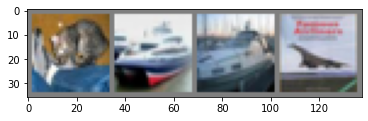

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [49]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = vgg_18(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [50]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg_18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of VGG18 with Adam on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of VGG18 on the 10000 test images: 82 %


In [51]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg_18(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86 %
Accuracy of   car : 90 %
Accuracy of  bird : 70 %
Accuracy of   cat : 73 %
Accuracy of  deer : 84 %
Accuracy of   dog : 69 %
Accuracy of  frog : 86 %
Accuracy of horse : 86 %
Accuracy of  ship : 90 %
Accuracy of truck : 84 %


#### VGG34 Adam

In [52]:
avg_losses_vgg34_adam = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 1000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        adam_opt.zero_grad()

        # Forward step.
        outputs = vgg_34(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        adam_opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses_vgg34_adam.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:   999] avg mini-batch loss: 2.365
[epoch: 0, i:  1999] avg mini-batch loss: 2.374
[epoch: 0, i:  2999] avg mini-batch loss: 2.372
[epoch: 0, i:  3999] avg mini-batch loss: 2.388
[epoch: 0, i:  4999] avg mini-batch loss: 2.369
[epoch: 0, i:  5999] avg mini-batch loss: 2.370
[epoch: 0, i:  6999] avg mini-batch loss: 2.372
[epoch: 0, i:  7999] avg mini-batch loss: 2.368
[epoch: 0, i:  8999] avg mini-batch loss: 2.370
[epoch: 0, i:  9999] avg mini-batch loss: 2.380
[epoch: 0, i: 10999] avg mini-batch loss: 2.376
[epoch: 0, i: 11999] avg mini-batch loss: 2.364
[epoch: 1, i:   999] avg mini-batch loss: 2.376
[epoch: 1, i:  1999] avg mini-batch loss: 2.383
[epoch: 1, i:  2999] avg mini-batch loss: 2.380
[epoch: 1, i:  3999] avg mini-batch loss: 2.377
[epoch: 1, i:  4999] avg mini-batch loss: 2.371
[epoch: 1, i:  5999] avg mini-batch loss: 2.385
[epoch: 1, i:  6999] avg mini-batch loss: 2.363
[epoch: 1, i:  7999] avg mini-batch loss: 2.382
[epoch: 1, i:  8999] avg mini-batch loss

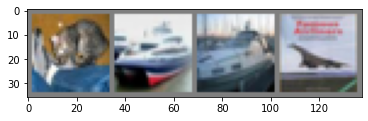

GroundTruth:    cat  ship  ship plane
Predicted:  plane  frog  frog  frog


In [53]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = vgg_34(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [54]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg_34(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of VGG34 with Adam on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of VGG18 on the 10000 test images: 11 %


In [55]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg_34(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 16 %
Accuracy of   car :  8 %
Accuracy of  bird :  0 %
Accuracy of   cat :  1 %
Accuracy of  deer : 21 %
Accuracy of   dog :  0 %
Accuracy of  frog : 58 %
Accuracy of horse : 11 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


#### Plot for VGG18 and VGG34 with Adam

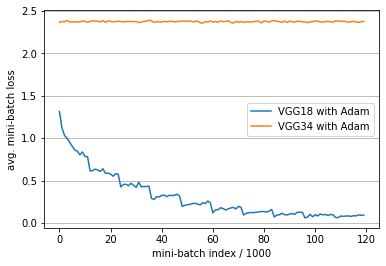

In [56]:
plt.plot(avg_losses_vgg18_adam, label='VGG18 with Adam')
plt.plot(avg_losses_vgg34_adam, label='VGG34 with Adam')
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.grid(axis='y')
plt.legend()
plt.show()

#### ResNet18 SGD

In [58]:
avg_losses_resnet18_sgd = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 1000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        sgd_opt.zero_grad()

        # Forward step.
        outputs = resnet_18(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        sgd_opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses_resnet18_sgd.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:   999] avg mini-batch loss: 2.385
[epoch: 0, i:  1999] avg mini-batch loss: 2.395
[epoch: 0, i:  2999] avg mini-batch loss: 2.381
[epoch: 0, i:  3999] avg mini-batch loss: 2.378
[epoch: 0, i:  4999] avg mini-batch loss: 2.377
[epoch: 0, i:  5999] avg mini-batch loss: 2.384
[epoch: 0, i:  6999] avg mini-batch loss: 2.384
[epoch: 0, i:  7999] avg mini-batch loss: 2.387
[epoch: 0, i:  8999] avg mini-batch loss: 2.395
[epoch: 0, i:  9999] avg mini-batch loss: 2.372
[epoch: 0, i: 10999] avg mini-batch loss: 2.383
[epoch: 0, i: 11999] avg mini-batch loss: 2.385
[epoch: 1, i:   999] avg mini-batch loss: 2.375
[epoch: 1, i:  1999] avg mini-batch loss: 2.392
[epoch: 1, i:  2999] avg mini-batch loss: 2.384
[epoch: 1, i:  3999] avg mini-batch loss: 2.392
[epoch: 1, i:  4999] avg mini-batch loss: 2.393
[epoch: 1, i:  5999] avg mini-batch loss: 2.375
[epoch: 1, i:  6999] avg mini-batch loss: 2.389
[epoch: 1, i:  7999] avg mini-batch loss: 2.383
[epoch: 1, i:  8999] avg mini-batch loss

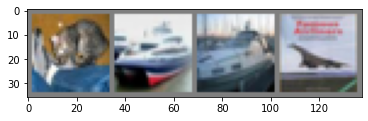

GroundTruth:    cat  ship  ship plane
Predicted:   frog  frog   car  frog


In [59]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = resnet_18(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [60]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of ResNet18 with SGD on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of ResNet18 with SGD on the 10000 test images: 10 %


In [61]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_18(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 12 %
Accuracy of   car :  7 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog : 80 %
Accuracy of horse :  0 %
Accuracy of  ship :  1 %
Accuracy of truck :  0 %


#### ResNet34 SGD

In [62]:
avg_losses_resnet34_sgd = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 1000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        sgd_opt.zero_grad()

        # Forward step.
        outputs = resnet_34(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        sgd_opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses_resnet34_sgd.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:   999] avg mini-batch loss: 2.629
[epoch: 0, i:  1999] avg mini-batch loss: 2.630
[epoch: 0, i:  2999] avg mini-batch loss: 2.631
[epoch: 0, i:  3999] avg mini-batch loss: 2.630
[epoch: 0, i:  4999] avg mini-batch loss: 2.643
[epoch: 0, i:  5999] avg mini-batch loss: 2.652
[epoch: 0, i:  6999] avg mini-batch loss: 2.627
[epoch: 0, i:  7999] avg mini-batch loss: 2.644
[epoch: 0, i:  8999] avg mini-batch loss: 2.650
[epoch: 0, i:  9999] avg mini-batch loss: 2.650
[epoch: 0, i: 10999] avg mini-batch loss: 2.630
[epoch: 0, i: 11999] avg mini-batch loss: 2.632
[epoch: 1, i:   999] avg mini-batch loss: 2.633
[epoch: 1, i:  1999] avg mini-batch loss: 2.641
[epoch: 1, i:  2999] avg mini-batch loss: 2.642
[epoch: 1, i:  3999] avg mini-batch loss: 2.635
[epoch: 1, i:  4999] avg mini-batch loss: 2.621
[epoch: 1, i:  5999] avg mini-batch loss: 2.630
[epoch: 1, i:  6999] avg mini-batch loss: 2.622
[epoch: 1, i:  7999] avg mini-batch loss: 2.644
[epoch: 1, i:  8999] avg mini-batch loss

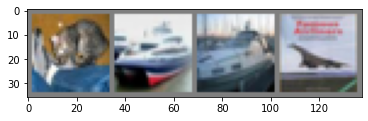

GroundTruth:    cat  ship  ship plane
Predicted:   deer  deer  deer  deer


In [63]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = resnet_34(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [64]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_34(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of ResNet34 with SGD on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of ResNet34 with SGD on the 10000 test images: 10 %


In [65]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_34(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer : 100 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


#### Plot for ResNet18 and ResNet34 with SGD

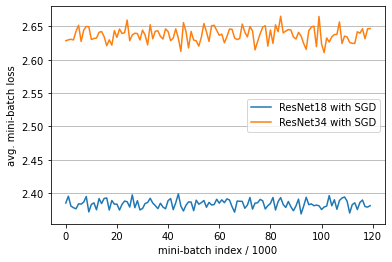

In [66]:
plt.plot(avg_losses_resnet18_sgd, label='ResNet18 with SGD')
plt.plot(avg_losses_resnet34_sgd, label='ResNet34 with SGD')
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.grid(axis='y')
plt.legend()
plt.show()

#### ResNet18 Adam

In [67]:
avg_losses_resnet18_adam = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 1000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        adam_opt.zero_grad()

        # Forward step.
        outputs = resnet_18(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        adam_opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses_resnet18_adam.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:   999] avg mini-batch loss: 2.392
[epoch: 0, i:  1999] avg mini-batch loss: 2.384
[epoch: 0, i:  2999] avg mini-batch loss: 2.380
[epoch: 0, i:  3999] avg mini-batch loss: 2.384
[epoch: 0, i:  4999] avg mini-batch loss: 2.391
[epoch: 0, i:  5999] avg mini-batch loss: 2.385
[epoch: 0, i:  6999] avg mini-batch loss: 2.378
[epoch: 0, i:  7999] avg mini-batch loss: 2.384
[epoch: 0, i:  8999] avg mini-batch loss: 2.375
[epoch: 0, i:  9999] avg mini-batch loss: 2.388
[epoch: 0, i: 10999] avg mini-batch loss: 2.391
[epoch: 0, i: 11999] avg mini-batch loss: 2.384
[epoch: 1, i:   999] avg mini-batch loss: 2.386
[epoch: 1, i:  1999] avg mini-batch loss: 2.383
[epoch: 1, i:  2999] avg mini-batch loss: 2.380
[epoch: 1, i:  3999] avg mini-batch loss: 2.384
[epoch: 1, i:  4999] avg mini-batch loss: 2.380
[epoch: 1, i:  5999] avg mini-batch loss: 2.386
[epoch: 1, i:  6999] avg mini-batch loss: 2.381
[epoch: 1, i:  7999] avg mini-batch loss: 2.385
[epoch: 1, i:  8999] avg mini-batch loss

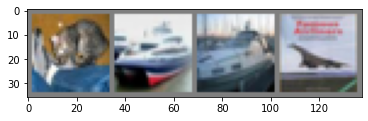

GroundTruth:    cat  ship  ship plane
Predicted:   frog  frog   car  frog


In [68]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = resnet_18(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [69]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of ResNet18 with Adam on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of ResNet18 with Adam on the 10000 test images: 10 %


In [70]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_18(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 12 %
Accuracy of   car :  7 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog : 80 %
Accuracy of horse :  0 %
Accuracy of  ship :  1 %
Accuracy of truck :  0 %


#### ResNet34 Adam

In [71]:
avg_losses_resnet34_adam = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 1000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        adam_opt.zero_grad()

        # Forward step.
        outputs = resnet_34(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        adam_opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses_resnet34_adam.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:   999] avg mini-batch loss: 2.614
[epoch: 0, i:  1999] avg mini-batch loss: 2.609
[epoch: 0, i:  2999] avg mini-batch loss: 2.651
[epoch: 0, i:  3999] avg mini-batch loss: 2.647
[epoch: 0, i:  4999] avg mini-batch loss: 2.638
[epoch: 0, i:  5999] avg mini-batch loss: 2.649
[epoch: 0, i:  6999] avg mini-batch loss: 2.671
[epoch: 0, i:  7999] avg mini-batch loss: 2.618
[epoch: 0, i:  8999] avg mini-batch loss: 2.653
[epoch: 0, i:  9999] avg mini-batch loss: 2.623
[epoch: 0, i: 10999] avg mini-batch loss: 2.628
[epoch: 0, i: 11999] avg mini-batch loss: 2.647
[epoch: 1, i:   999] avg mini-batch loss: 2.662
[epoch: 1, i:  1999] avg mini-batch loss: 2.618
[epoch: 1, i:  2999] avg mini-batch loss: 2.629
[epoch: 1, i:  3999] avg mini-batch loss: 2.647
[epoch: 1, i:  4999] avg mini-batch loss: 2.630
[epoch: 1, i:  5999] avg mini-batch loss: 2.610
[epoch: 1, i:  6999] avg mini-batch loss: 2.653
[epoch: 1, i:  7999] avg mini-batch loss: 2.628
[epoch: 1, i:  8999] avg mini-batch loss

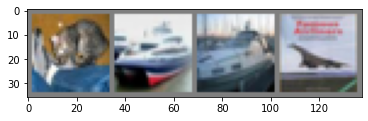

GroundTruth:    cat  ship  ship plane
Predicted:   deer  deer  deer  deer


In [72]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = resnet_34(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [73]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_34(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of ResNet34 with Adam on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of ResNet34 with Adam on the 10000 test images: 10 %


In [74]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_34(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer : 100 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


#### Plot for ResNet18 and ResNet34 with Adam

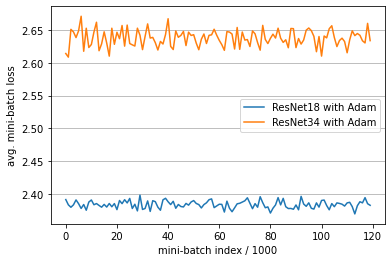

In [75]:
plt.plot(avg_losses_resnet18_adam, label='ResNet18 with Adam')
plt.plot(avg_losses_resnet34_adam, label='ResNet34 with Adam')
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.grid(axis='y')
plt.legend()
plt.show()